c:\Users\Forwa\Documents\Code\Practical Machine Learning\.venv\Lib\site-packages\magpylib\_src\fields\field_BH_circle.py:115: RuntimeWarning: overflow encountered in power
  (r0[mask4] ** 2 / (z[mask4] ** 2 + r0[mask4] ** 2) ** (3 / 2))
c:\Users\Forwa\Documents\Code\Practical Machine Learning\.venv\Lib\site-packages\magpylib\_src\fields\field_BH_circle.py:115: RuntimeWarning: overflow encountered in square
  (r0[mask4] ** 2 / (z[mask4] ** 2 + r0[mask4] ** 2) ** (3 / 2))
C:\Users\Forwa\AppData\Local\Temp\ipykernel_21916\2169733621.py:99: RuntimeWarning: overflow encountered in scalar divide
  acceleration = force / mass  # Newton's second law: F = ma


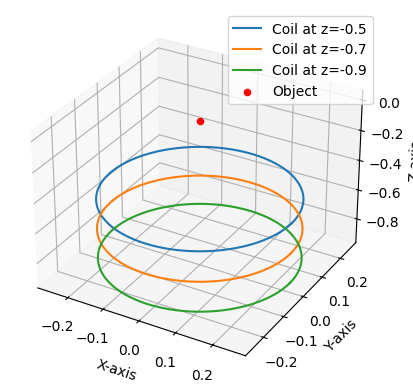

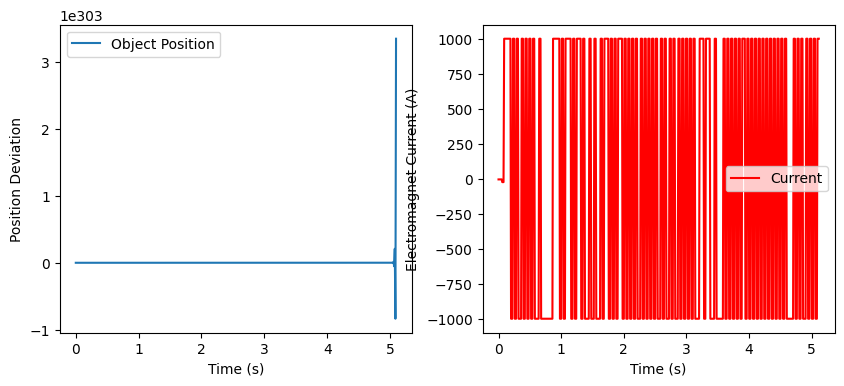

In [ ]:
import math
import magpylib as magpy
import numpy as np
from simple_pid import PID
import matplotlib.pyplot as plt

# PID controller to regulate the current in the electromagnet
pid = PID(10.0, 0.5, 0.2, setpoint=0)  # Stronger Kp for faster correction
pid.output_limits = (-1000, 1000)      # Increased current range to allow stronger correction

# Simulation setup
time_steps = np.linspace(0, 10, 1000)  # Simulating 10 seconds
dt = time_steps[1] - time_steps[0]     # Time step for simulation
object_positions = []
current_values = []

# Initial object conditions
object_position = 0.5  # Deviation from setpoint
object_velocity = 0.0  # Initial velocity
mass = 0.1             # Object mass

def make_coil(current, num_coils, coil_spacing, position,  diameter = 0.01):
    x, y, z = position 
    coils = []
    for i in range(num_coils):
        coil = magpy.current.Circle(
            current=current, 
            diameter= diameter, 
            position=(x, y, z - i * coil_spacing)
        )
        coils.append(coil)
    
    return coils

def get_magnetic_field_at_object_multi_coils(current, object_position, num_coils, coil_spacing, plot = False):
    """
    Creates multiple coils along the z-axis and calculates the total magnetic field at a given object's position.
    
    :param current: Current in each coil (A)
    :param object_position: z-position of the object where the field is calculated
    :param num_coils: Number of coils in the system
    :param coil_spacing: Spacing between adjacent coils along the z-axis
    :return: Total Bz magnetic field at the object's position
    """
    diameter = 0.5 
    coils = [magpy.current.Circle(current=current, diameter=diameter, position=(0, 0, -0.5 + -i * coil_spacing)) for i in range(num_coils)]
    
    total_field = sum(coil.getB([0, 0, object_position])[2] for coil in coils)  # Summing Bz component
    total_field = total_field * 1000 


    
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        theta = np.linspace(0, 2 * np.pi, 100)
        for coil in coils:
            x = (diameter / 2) * np.cos(theta)
            y = (diameter / 2) * np.sin(theta)
            z = np.full_like(theta, coil.position[2])
            ax.plot(x, y, z, label=f'Coil at z={coil.position[2]}')
        ax.scatter(0, 0, 0, color='red', label='Object')
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_zlabel("Z-axis")
        ax.legend()
        plt.show()
    
    return total_field


# Compute force based on field gradient
def compute_force(current, object_position, delta_x=1e-3):
    num_coils = 10  # Number of coils
    coil_spacing = 0.2  # meters
    B1 = get_magnetic_field_at_object_multi_coils(current, object_position, num_coils, coil_spacing)
    B2 = get_magnetic_field_at_object_multi_coils(current, object_position + delta_x, num_coils, coil_spacing)
    dB2_dx = (B2**2 - B1**2) / delta_x  # Approximate gradient of B^2
    force = -dB2_dx  # Flip sign to ensure force is opposing gravity

    return force # Scale force to strongly counteract gravity


# Compute net force on the object including gravity and damping force
def net_force(current, object_position, velocity, mass, gravity=9.81, delta_x=1e-3, damping_coefficient=50):
    magnetic_force = compute_force(current, object_position, delta_x)
    
    gravitational_force = -mass * gravity  # Gravity pulls downward
    damping_force = -damping_coefficient * velocity  # Damping force opposes motion
    #print(magnetic_force)
    #print(gravitational_force)
    return magnetic_force + gravitational_force + damping_force  # Net force as sum of all forces

# Simulate PID-controlled electromagnet
for t in time_steps:
    error = object_position - pid.setpoint
    current = pid(error)  # Adjust current based on PID
    force = net_force(current, object_position, object_velocity, mass)  # Compute net force
    acceleration = force / mass  # Newton's second law: F = ma
    object_velocity += acceleration * dt  # Update velocity
    object_position += object_velocity * dt  # Update position
    
    object_positions.append(object_position)
    current_values.append(current)

get_magnetic_field_at_object_multi_coils(current, object_position, num_coils=3, coil_spacing=0.2 , plot = True)

# Plot results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(time_steps, object_positions, label='Object Position')
plt.xlabel('Time (s)')
plt.ylabel('Position Deviation')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_steps, current_values, label='Current', color='r')
plt.xlabel('Time (s)')
plt.ylabel('Electromagnet Current (A)')
plt.legend()

plt.show()


In [9]:
# Generate 4 coil pillars in a square formation with 2cm spacing
coil_pillars = []
square_spacing = 2  # 2 cm spacing
positions = [(-square_spacing, -square_spacing), (-square_spacing, square_spacing), 
             (square_spacing, -square_spacing), (square_spacing, square_spacing)]

for x, y in positions:
    coil_pillars.append(make_coil(current=1, x_center=x, y_center=y, z_start=10, num_coils=20, coil_spacing=0.5, radius=2))


"""Plots multiple coil pillars."""
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
    
for coils in coil_pillars:
    for coil in coils:
        x, y, z = coil.position
        circle_theta = np.linspace(0, 2 * np.pi, 100)
        x_circle = x + (coil.diameter / 2) * np.cos(circle_theta)
        y_circle = y + (coil.diameter / 2) * np.sin(circle_theta)
        z_circle = np.full_like(circle_theta, z)
        ax.plot(x_circle, y_circle, z_circle, '-b')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Coil Pillars')
plt.show()


TypeError: make_coil() got an unexpected keyword argument 'current'

In [6]:
# Compute force based on field gradient
def compute_force(current, object_position, delta_x=1e-3):
    num_coils = 10  # Number of coils
    coil_spacing = 0.2  # meters
    B1 = get_magnetic_field_at_object_multi_coils(current, object_position, num_coils, coil_spacing)
    B2 = get_magnetic_field_at_object_multi_coils(current, object_position + delta_x, num_coils, coil_spacing)
    dB2_dx = (B2**2 - B1**2) / delta_x  # Approximate gradient of B^2
    force = -dB2_dx  # Flip sign to ensure force is opposing gravity

    #print (force )
    print(f"Current: {current:.2f} A, B1: {B1:.6f}, B2: {B2:.6f}, dB2_dx: {dB2_dx:.6f}, Force: {force:.6f}")

    return force # Scale force to strongly counteract gravity


def find_equilibrium_current(initial_guess, object_position, mass, tolerance=1e-3, max_iterations=100):
    """
    Finds the required current to balance the force of gravity on an object.

    :param initial_guess: Initial guess for current (A)
    :param object_position: z-position of the object
    :param mass: Mass of the object (kg)
    :param tolerance: Convergence tolerance for force balance (N)
    :param max_iterations: Maximum number of iterations for convergence
    :return: Required current to balance gravity
    """
    current = initial_guess
    velocity = 0  # Assume initial velocity is zero

    for _ in range(max_iterations):
        net_f = net_force(current, object_position, velocity, mass)

        if abs(net_f) < tolerance:

            print(f"Required current to balance gravity: {current:.4f} A")
            return current  # Found a good equilibrium current


        # Adjust current using a simple proportional controller
        current += -100000 * net_f  # Tune step size if needed
    print(net_f)
    print("Did not converge to an equilibrium current within tolerance.")

# Example usage:
mass_of_object = 0.1  # kg
object_z_position = 0.05  # meters
initial_current_guess = 10.0  # Amps

required_current = find_equilibrium_current(initial_current_guess, object_z_position, mass_of_object)


Current: 10.00 A, B1: 0.003675, B2: 0.003662, dB2_dx: -0.000099, Force: 0.000099
Current: 98100.09 A, B1: 36.053988, B2: 35.921484, dB2_dx: -9537.047441, Force: 9537.047441
Current: -953508544.04 A, B1: -350435.819534, B2: -349147.912225, dB2_dx: -900999001272.430420, Force: 900999001272.430420
Current: -90099901080653488.00 A, B1: -33113738594688.492188, B2: -32992040344733.621094, dB2_dx: -8044957608831164692299776000.000000, Force: 8044957608831164692299776000.000000
Current: -804495760883116592023436190023680.00 A, B1: -295670272740607144105552642048.000000, B2: -294583637516580086304106086400.000000, dB2_dx: -641390690005173465854002188626567495028147822218685972480000.000000, Force: 641390690005173465854002188626567495028147822218685972480000.000000
Current: -64139069000517352251573558905317477304210080936364288687504097280.00 A, B1: -23572549349289643955649601055640906039919863796498824301641728.000000, B2: -23485916485574172012506012659713150256288033588925923279765504.000000, 

C:\Users\Forwa\AppData\Local\Temp\ipykernel_21916\791191992.py:7: RuntimeWarning: overflow encountered in scalar power
  dB2_dx = (B2**2 - B1**2) / delta_x  # Approximate gradient of B^2
C:\Users\Forwa\AppData\Local\Temp\ipykernel_21916\791191992.py:7: RuntimeWarning: invalid value encountered in scalar subtract
  dB2_dx = (B2**2 - B1**2) / delta_x  # Approximate gradient of B^2
